In [4]:
# Base packages
import dill
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud
import os,re, nltk, spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Path
folders = './final/'
file_url = folders + 'lematize_corpus_vec.csv'

model_folders = './models/'
dest_model_file_a = model_folders + 'lda_tfidf_uni_a.pkl'
dest_model_file_b = model_folders + 'lda_tfidf_uni_b.jlb'
dest_model_file_c = model_folders + 'lda_tfidf_uni_c_dill.pkl'

gs_model_bk = './gs_models/tfidf_uni.model'
dest_df = './dataframe/tfidf_uni.csv'
dest_vec = './vectorizer/tfidf_uni.vector'

# Init
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
GRAMMAGE = (1, 1)
%matplotlib inline

# Custom
%run -i ./python-code/helper.py
%run -i ./python-code/config.py
%run -i ./python-code/nlp_scripts.py

In [2]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [5]:
frame = pd.read_csv(file_url, sep='|', encoding="utf-8")
frame.head()

,text,list_text,lemma_text
0,People with an irregular heart beat condition...,"['people', 'with', 'an', 'irregular', 'heart',...",peopl irregular heart beat condit should be cl...
1,Politicians in the Catholic Republic of Irelan...,"['politicians', 'in', 'the', 'catholic', 'repu...",politician cathol republ ireland have overwhel...
2,In the winter months temperatures and humidity...,"['in', 'the', 'winter', 'months', 'temperature...",winter month temperatur humid level plummet as...
3,A system of special measures designed to impro...,"['system', 'of', 'special', 'measures', 'desig...",system special measur design improv fail hospi...
4,A can be hard enough to get on your own Add in...,"['can', 'be', 'hard', 'enough', 'to', 'get', '...",can be hard enough get own add challeng sleep ...


In [6]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25737 entries, 0 to 25736
Data columns (total 3 columns):
text          25737 non-null object
list_text     25737 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 603.3+ KB


In [7]:
frame = frame[pd.notnull(frame['lemma_text'])]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25729 entries, 0 to 25736
Data columns (total 3 columns):
text          25729 non-null object
list_text     25729 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 804.0+ KB


In [8]:
corpus = frame['lemma_text'].values

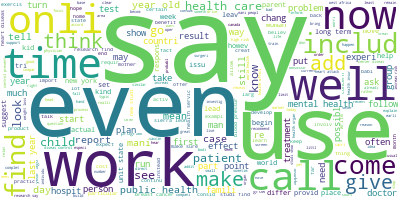

In [7]:
# Join the different processed title together.
long_string = ','.join(corpus)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [8]:
# Split corpus into TRAIN, TEST, HOLDON
data_train = corpus[:TRAIN_SIZE]
TRAIN_SIZE = TRAIN_SIZE +1
TEST_SIZE = TEST_SIZE + TRAIN_SIZE
data_test = corpus[TRAIN_SIZE:TEST_SIZE]
TEST_SIZE = TEST_SIZE + 1
data_holdon = corpus[TEST_SIZE:]

In [9]:
# Create the Document-Word matrix
vectorizer = TfidfVectorizer(ngram_range = GRAMMAGE,
                             analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=M_STOP_WORDS,   # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(corpus)

In [10]:
# 8. Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.0562687842106142 %


In [11]:
# Build LDA Model
lda_model = LDA(n_topics=E_TOPICS,       # Number of topics
              max_iter=10,               # Max learning iterations
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every = -1,       # compute perplexity every n iters, default: Don't
              n_jobs = -1,               # Use all available CPUs
             )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=6, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [12]:
# 10
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1942002.471872421
Perplexity:  7322.833850253756
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 6,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [14]:
## GridSearchCV
# Define Search Param
search_params = {'n_components': N_COMPONENTS, 'learning_decay': LEARNING_DECAY}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_components': [6, 10, 15, 20, 25, 30, 50], 'learning_decay': ['.3', '.5', '.7', '.9']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': '.9', 'n_components': 6}
Best Log Likelihood Score:  -678348.9338199922
Model Perplexity:  7366.741039849702


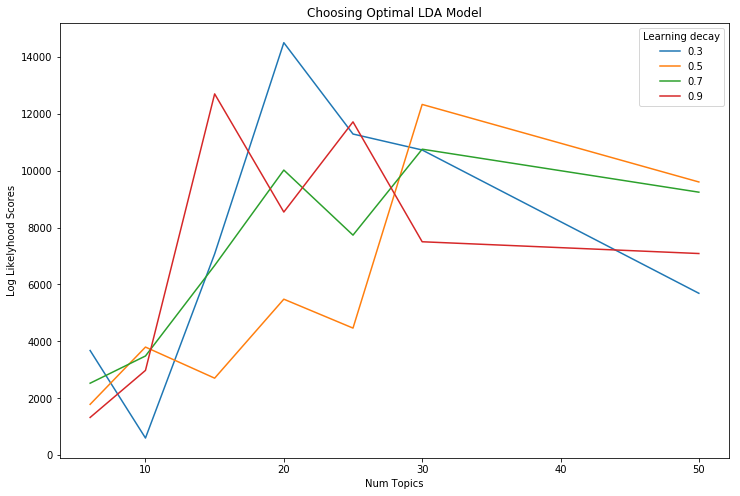

In [15]:
# Get Log Likelyhoods from Grid Search Output
n_topics = search_params['n_components']
learning_decay = LEARNING_DECAY
one_third = len(n_topics)
two_third = one_third*2
three_fourth = one_third*3

gscore = dict(model.cv_results_)
log_likelyhoods_3 = gscore['std_train_score'][0:one_third]
log_likelyhoods_5 = gscore['std_train_score'][one_third:two_third]
log_likelyhoods_7 = gscore['std_train_score'][two_third:three_fourth]
log_likelyhoods_9 = gscore['std_train_score'][three_fourth:]


# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


### 1. Saving Models 

In [18]:
# Have: best_lda_model


## ----------------------------------------------------------
## ----------------------------------------------------------
## Pickle
## ----------------------------------------------------------
pickle.dump(best_lda_model,open(dest_model_file_a,'wb'))

## Joblib
## ----------------------------------------------------------
joblib.dump(best_lda_model, dest_model_file_b)

## Dill
## ----------------------------------------------------------
dill.dump(best_lda_model, open(dest_model_file_c,'wb'))

## Vectorizer
## ----------------------------------------------------------
dill.dump(vectorizer, open(dest_vec,'wb'))


## ----------------------------------------------------------
## ----------------------------------------------------------
## Backup GridSearchCV models
## ----------------------------------------------------------
dill.dump(model, open(gs_model_bk,'wb'))

## Best topic
## ----------------------------------------------------------
BEST_TOPICS = model.best_params_['n_components']

In [13]:
# best_lda_model = dill.load(open(dest_model_file_c,'rb'))

In [20]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(model.best_params_['n_components'])]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.02,0.02,0.02,0.02,0.9,0.02,4
Doc1,0.03,0.03,0.03,0.03,0.85,0.03,4
Doc2,0.17,0.01,0.49,0.3,0.01,0.01,2
Doc3,0.02,0.02,0.02,0.02,0.92,0.02,4
Doc4,0.94,0.01,0.01,0.01,0.01,0.01,0
Doc5,0.02,0.02,0.02,0.02,0.92,0.02,4
Doc6,0.01,0.01,0.01,0.45,0.01,0.49,5
Doc7,0.54,0.03,0.03,0.03,0.35,0.03,0
Doc8,0.02,0.38,0.02,0.02,0.53,0.02,4
Doc9,0.02,0.02,0.02,0.02,0.59,0.34,4


In [21]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,13726
1,0,4281
2,2,3487
3,5,2063
4,3,1201
5,1,971


In [27]:
df_document_topic['dominant_topic'].value_counts(normalize=True)

4    0.533484
0    0.166388
2    0.135528
5    0.080182
3    0.046679
1    0.037740
Name: dominant_topic, dtype: float64

In [22]:
df_document_topic.to_csv(dest_df, sep='|')

In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Shaynie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4     -460.406342  138.951096       1        1  50.000878
0       53.895882  540.297424       2        1  16.055236
2       72.907921  -14.278211       3        1  13.240275
5      594.471130  175.226501       4        1   9.277107
3     -237.570419 -474.186584       5        1   6.472990
1      414.368042 -451.692963       6        1   4.953513, topic_info=      Category        Freq           Term       Total  loglift  logprob
term                                                                   
1940   Default  455.000000         cancer  455.000000  30.0000  30.0000
4977   Default  366.000000           food  366.000000  29.0000  29.0000
3973   Default  438.000000           drug  438.000000  28.0000  28.0000
14007  Default  309.000000          virus  309.000000  27.0000  27.0000
13831  Default  304.000000         vaccin  304.000000  26.0000  26.0000
4077   Default  284.000000            eat  284.000000  25.0000  25.0000
4525   Default  218.000000        exercis  218.000000  24.0000  24.0000
9146   Default  217.000000       outbreak  217.000000  23.0000  23.0000
14366  Default  421.000000          woman  421.000000  22.0000  22.0000
6491   Default  286.000000         infect  286.000000  21.0000  21.0000
1911   Default  213.000000         calori  213.000000  20.0000  20.0000
4682   Default  218.000000            fat  218.000000  19.0000  19.0000
14202  Default  251.000000         weight  251.000000  18.0000  18.0000
12546  Default  160.000000          sugar  160.000000  17.0000  17.0000
3636   Default  178.000000           diet  178.000000  16.0000  16.0000
4934   Default  160.000000            flu  160.000000  15.0000  15.0000
2066   Default  321.000000           case  321.000000  14.0000  14.0000
12474  Default  546.000000          studi  546.000000  13.0000  13.0000
1627   Default  245.000000          brain  245.000000  12.0000  12.0000
3953   Default  199.000000          drink  199.000000  11.0000  11.0000
2700   Default  213.000000        compani  213.000000  10.0000  10.0000
11176  Default  177.000000            run  177.000000   9.0000   9.0000
1666   Default  149.000000         breast  149.000000   8.0000   8.0000
265    Default  134.000000         africa  134.000000   7.0000   7.0000
7399   Default  123.000000        liberia  123.000000   6.0000   6.0000
3732   Default  390.000000         diseas  390.000000   5.0000   5.0000
4851   Default  113.000000            fit  113.000000   4.0000   4.0000
8994   Default  184.000000         offici  184.000000   3.0000   3.0000
14229  Default  137.000000           west  137.000000   2.0000   2.0000
11578  Default  111.000000            sex  111.000000   1.0000   1.0000
...        ...         ...            ...         ...      ...      ...
10247   Topic6   33.186294        prostat   44.979478   2.7010  -5.7861
8884    Topic6   13.569608        novarti   17.292666   2.7626  -6.6804
2775    Topic6   21.459762         condom   30.744186   2.6456  -6.2221
1940    Topic6  186.485923         cancer  455.625036   2.1118  -4.0599
9681    Topic6   38.200548     pharmaceut   71.065847   2.3843  -5.6454
116     Topic6   13.134454  acetaminophen   17.313484   2.7288  -6.7130
8049    Topic6   20.028250       menopaus   31.539947   2.5510  -6.2911
11581   Topic6   42.194939         sexual   96.674781   2.1760  -5.5459
7719    Topic6   31.393520          maker   63.202553   2.3053  -5.8416
11578   Topic6   45.066452            sex  111.022826   2.1035  -5.4801
1666    Topic6   52.325976         breast  149.901772   1.9526  -5.3308
5312    Topic6   20.293302        generic   34.157716   2.4844  -6.2780
3973    Topic6   90.423290           drug  438.440451   1.4264  -4.7837
14366   Topic6   76.909119          woman  421.727319   1.3033  -4.9456
4706    Topic6   38.036170            fda  115.799453   1.8918  -5.6497
10186   Topic6   39.873893        pro

In [38]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,aaa,aafter,aall,aalmost,aan,aand,aani,aanyth,aap,aar,...,zoloft,zombi,zone,zoo,zoom,zoonot,zucchini,zucker,zuckerman,zumba
Topic0,0.166684,0.166676,0.173924,0.166672,0.166731,0.166673,0.166683,0.166683,0.565144,0.166683,...,0.166678,0.167377,1.311805,0.300944,0.166881,0.498090,0.166669,0.166685,0.408406,0.166670
Topic1,0.167438,0.173037,0.166810,0.166669,0.244765,0.171501,0.167816,0.377786,0.608311,0.170664,...,0.166671,0.167756,1.317374,0.359600,0.167138,0.318804,12.076394,0.168969,0.166758,0.167618
Topic2,0.167178,0.166942,0.168599,0.167341,0.166954,0.166867,0.172574,0.166669,0.167395,0.169427,...,0.166668,0.167561,8.921441,0.167707,0.508771,1.351776,0.166667,0.167815,0.168572,0.166667
Topic3,0.167201,0.166682,0.166686,0.166676,0.166708,0.166720,0.166692,0.166691,0.570401,0.166689,...,0.166686,0.166986,0.166963,0.166684,0.166695,0.166683,0.166671,0.166786,0.166852,0.166671
Topic4,1.283926,1.223002,2.198322,0.776722,1.963666,3.448222,0.917550,0.474574,2.676949,1.766124,...,0.285022,3.040080,11.636501,1.128066,2.020414,0.167564,0.167833,1.129580,0.591258,3.502214
Topic5,0.231072,0.227469,0.486062,0.169196,0.517583,1.650961,0.233941,0.185850,0.204536,0.322580,...,0.749995,0.166902,0.578657,0.167225,0.342746,0.167753,0.166667,0.254575,1.363646,0.167080


In [34]:
# Show top n keywords for each topic
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=18)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17
Topic 0,vaccin,insur,flu,coverag,health,exchang,measl,state,enrol,virus,plan,law,afford,polio,feder,peopl,premium,strain
Topic 1,food,eat,calori,fat,sugar,diet,fruit,drink,oil,protein,product,healthi,bacteria,consum,veget,meal,contain,milk
Topic 2,health,patient,care,hospit,nhs,servic,peopl,virus,govern,need,nurs,year,doctor,case,outbreak,medic,staff,infect
Topic 3,drug,question,submit,compani,pharmaceut,maker,prescript,pill,pharmaci,contracept,fda,generic,pfizer,opioid,allergan,circumcis,health,sale
Topic 4,peopl,child,time,studi,feel,exercis,research,day,sleep,brain,year,make,just,parent,help,life,think,school
Topic 5,cancer,studi,research,woman,risk,diseas,drug,patient,smoke,heart,blood,peopl,year,age,child,obes,breast,percent


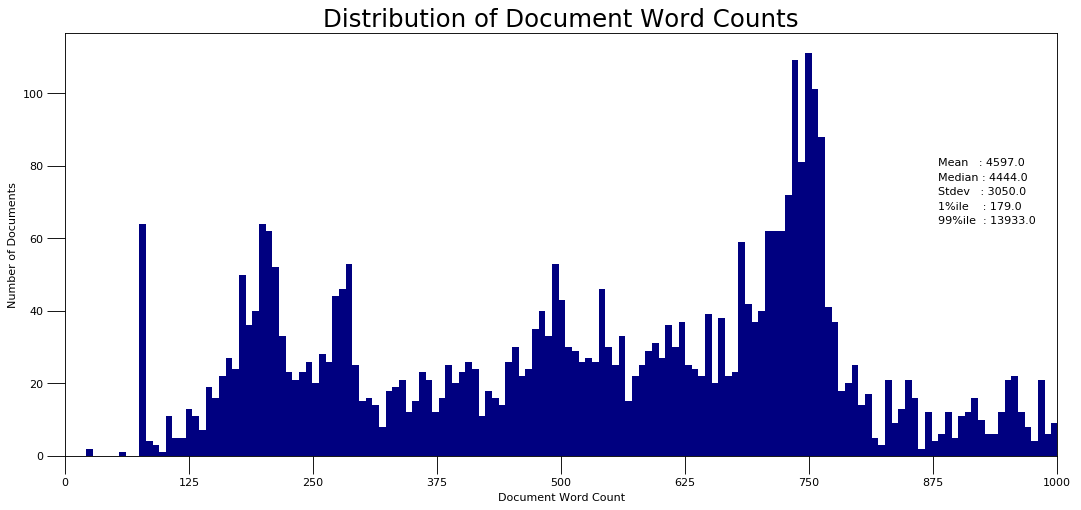

In [67]:
doc_lens = [len(d) for d in frame['list_text'].values]

# Plot
plt.figure(figsize=(16,7), dpi=80)
plt.hist(doc_lens, bins = 10000, color='navy')
plt.text(880, 80, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(880, 76, "Median : " + str(round(np.median(doc_lens))))
plt.text(880, 72, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(880, 68, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(880, 64, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [52]:
unseem_data = '''
Ultra-processed foods - such as chicken nuggets, ice cream and breakfast cereals - have been linked to early death and poor health, scientists say. 
Researchers in France and Spain say the amount of such food being eaten has soared.
Their studies are not definite proof of harm but do come hot on the heels of trials suggesting ultra-processed foods 
.
Experts expressed caution but called for further investigation. 
The term comes from a way of classifying food by how much industrial processing it has been through.
The lowest category is "unprocessed or minimally processed foods", which include: • fruit • vegetables • milk • meat • legumes such as lentils • seeds • grains such as rice • eggs
"Processed foods" have been altered to make them last longer or taste better - generally using salt, oil, sugar or fermentation.
This category includes: • cheese • bacon • home-made bread • tinned fruit and vegetables • smoked fish • beer
Then come "ultra-processed foods", which have been through more substantial industrial processing and often have long ingredient lists on the packet, including added preservatives, sweeteners or colour enhancers. 
If a product contains more than five ingredients, it is probably ultra-processed, says Prof Maira Bes-Rastrollo, of the University of Navarra, citing a maxim.
Examples include: • processed meat such as sausages and hamburgers • breakfast cereals or cereal bars • instant soups • sugary fizzy drinks • chicken nuggets • cake • chocolate • ice cream • mass-produced bread • many "ready to heat" meals such as pies and pizza | meal-replacement shakes 
, by the University of Navarra, in Spain, followed 19,899 people for a decade and assessed their diet every other year. There were 335 deaths during the study.
But for every 10 deaths among those eating the least ultra-processed food, there were 16 deaths among those eating the most (more than four portions a day).
, by the University of Paris, followed 105,159 people for five years and assessed their diet twice a year.
It showed those eating more ultra-processed food had worse heart health. 
Rates of cardiovascular disease were 277 per 100,000 people per year among those eating the most ultra-processed food, compared with 242 per 100,000 among those eating the least. 
The rapid increase of ultra-processed foods over less processed foods, "may drive a substantial burden of cardiovascular diseases in the next decades," said Dr Mathilde Touvier, of the University of Paris.
"[The] evidence is accumulating," said Dr Touvier, noting "increasing numbers of independent studies". Prof Bes-Rastrollo said she was "very certain" ultra-processed foods were bad for health.
Last year, a link was made with 
.
The challenge is being 100% sure. The studies have spotted a pattern between highly processed food and poor health but they cannot prove that one causes the other. 
Those who ate the most ultra-processed food were also more likely to have other unhealthy behaviours, such as smoking, which the researchers tried to account for. 
But there's no guarantee everything relevant was covered, says Kevin McConway, a professor of statistics at The Open University.
"These studies do increase my confidence that there's something real behind these associations - but I'm still far from sure."
The first trial of ultra-processed foods showed they led people to eat more and put on weight. 
Researchers at the US National Institutes of Health monitored every morsel of food that volunteers ate for a month.
And when given ultra-processed food, they ate 500 calories a day more than when they were given unprocessed meals.
Other suggestions include: 
These ideas still need researching.
While the term ultra-processed food may be new, the health advice will be very familiar: adopt a Mediterranean-style diet.
Such a diet includes plenty of minimally or unprocessed foods, such as fruit, vegetables, fish, nuts and seeds, beans, lentils and wholegrains, said Victoria Taylor, senior dietician at the British Heart Foundation.
"This, along with exercising regularly and not smoking, has been shown to be beneficial for lowering risk of heart and circulatory disease."
Measures such as taxation and marketing restrictions on ultra-processed foods, should be considered, said Prof Bes-Rastrollo, given the weight of evidence. 
There are certainly a lot of critics. 
The labelling of food as ultra-processed could be inconsistent, said Dr Gunter Kuhnle, an expert in nutrition and health at the University of Reading
"It is also not obvious why salami is considered to be ultra-processed, yet cheese, which often requires considerably more processing steps and additives, is not.  The classification combines a wide range of foods with very different potential impacts on health, which limits its usefulness as a basis for recommendations."
The studies were published in the British Medical Journal.
'''

In [26]:
# Define function to predict topic for a given text document.

# Predict the topic
# for text in data_test:
#     topic, prob_scores = predict_topic(text = text)
#     print(topic)
topic, prob_scores = predict_topic(unseem_data)
print(topic)
pprint(prob_scores)

[[0.01776347 0.69340323 0.0177432  0.01750934 0.01778272 0.23579805]] 1
['food', 'eat', 'calori', 'fat', 'sugar', 'diet', 'fruit', 'drink', 'oil', 'protein', 'product', 'healthi', 'bacteria', 'consum', 'veget']
array([[0.01776347, 0.69340323, 0.0177432 , 0.01750934, 0.01778272,
        0.23579805]])


### Fitting with KMeans

Component's weights: 
 [[ 0.1   0.05  0.07  0.05  0.99  0.07]
 [ 0.83  0.08  0.51  0.09 -0.14  0.16]]
Perc of Variance Explained: 
 [0.32 0.21]


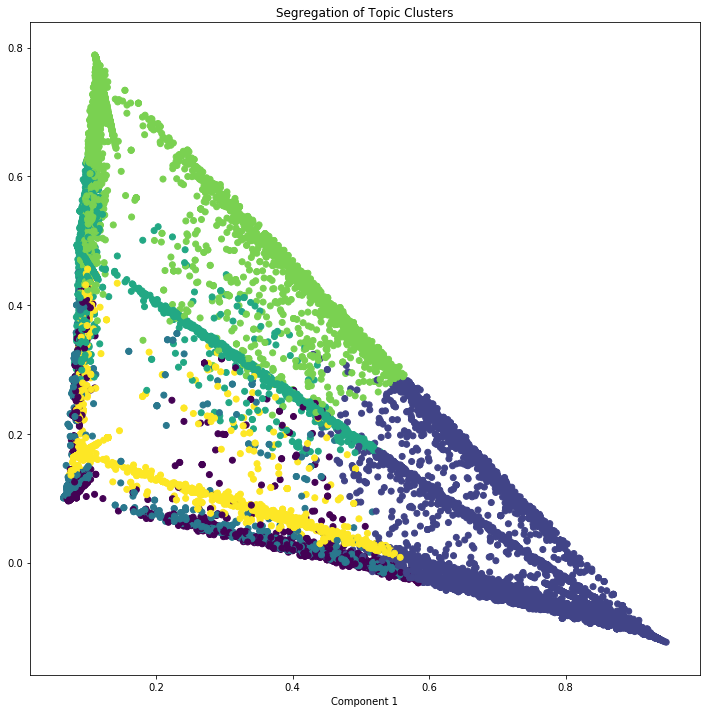

In [24]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=BEST_TOPICS, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plotting clusters
plotting_clusters(x, y, clusters)

In [29]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = corpus, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [30]:
# Get similar documents
doc_ids, docs = similar_documents(text=unseem_data, doc_topic_probs=lda_output, documents = corpus, top_n=1, verbose=True)
print('\n', docs[0][:500])

[[0.01776347 0.69340323 0.0177432  0.01750934 0.01778272 0.23579805]] 1
Topic KeyWords:  ['food', 'eat', 'calori', 'fat', 'sugar', 'diet', 'fruit', 'drink', 'oil', 'protein', 'product', 'healthi', 'bacteria', 'consum', 'veget']
Topic Prob Scores of text:  [[0.  0.7 0.  0.  0.  0.2]]
Most Similar Doc's Probs:   [[0.  0.7 0.  0.  0.  0.2]]

 child biolog make much more vulner sugar salt food new studi have confirm process toddler food often have high level add sugar sodium research center diseas control find food target child age quarter dinner have high sodium content third dinner contain add sugar major toddler snack contain add sugar earli studi canada reach similar find so decid look whi such high level occur answer be more interest peopl may expect toddler nutrit tip healthi kid toddler food excess sodium add sugar set tast pre


### Fitting with DBSCAN

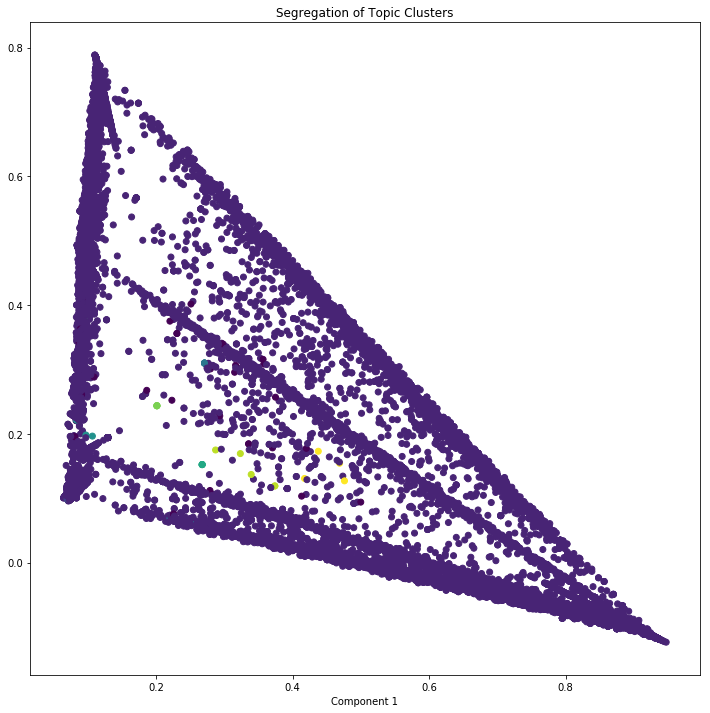

In [25]:
# Construct the DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# X = ss.fit_transform(lda_output)

dbscan_clusters = DBSCAN(eps=0.123, min_samples = 4).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plotting clusters
plotting_clusters(x, y, dbscan_clusters)